originally claud created and gemini extended for excell files

Reading files...
✓ Found 0 data points in stats of pich-off.rtf: []
✓ Found 3 data points in pinchoffV_0.02_txt.xltx: ['A', 'B', 'C']
✓ Found 3 data points in pinchoffV_0.05A_txt.xltx: ['A', 'B', 'C']


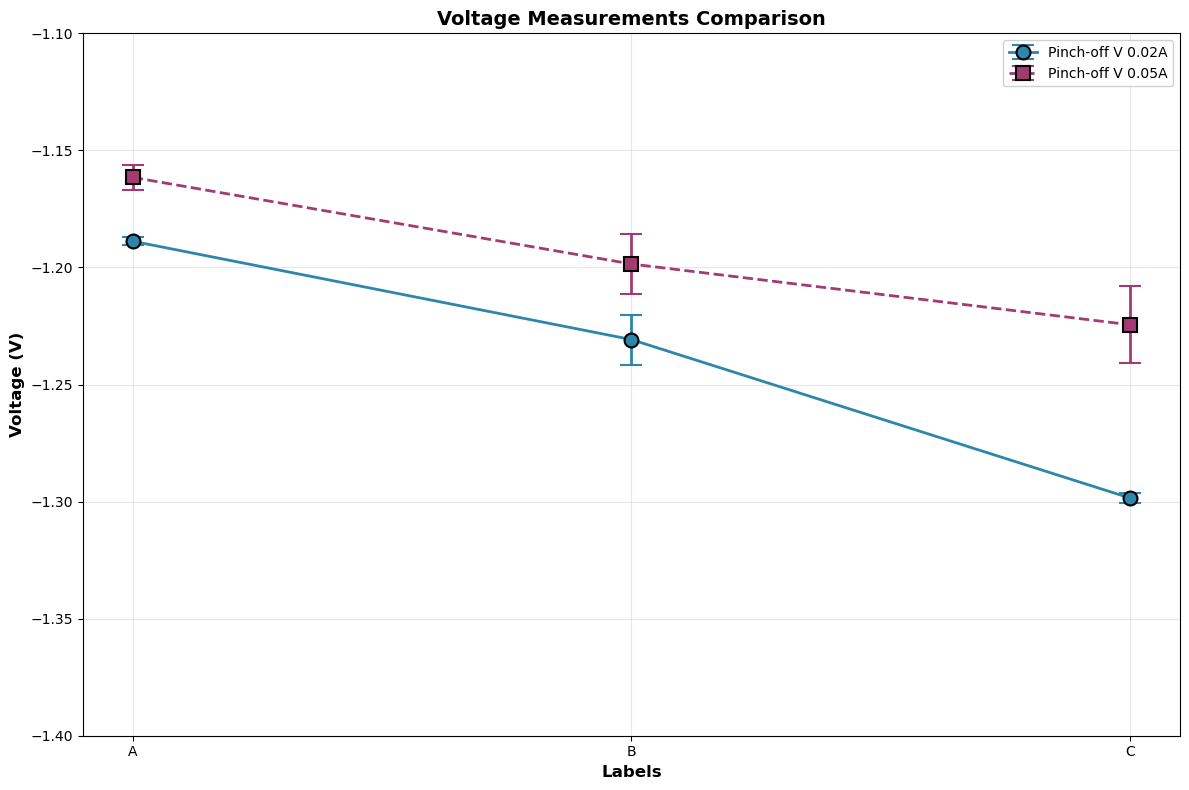


DATA SUMMARY

Pinch-off V 0.02A (pinchoffV_0.02_txt.xltx):
----------------------------------------
Label A: -1.188800 ± 0.001599 V
Label B: -1.230800 ± 0.010699 V
Label C: -1.298500 ± 0.002262 V

Pinch-off V 0.05A (pinchoffV_0.05A_txt.xltx):
----------------------------------------
Label A: -1.161530 ± 0.005261 V
Label B: -1.198516 ± 0.012934 V
Label C: -1.224475 ± 0.016365 V

Figures saved as 'voltage_comparison_plot.png' and 'voltage_comparison_plot.pdf'


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import re
import openpyxl

# --- Configuration ---
# Set the desired Y-axis range. Use None for automatic scaling.
y_axis_min = -1.4
y_axis_max = -1.1

def read_rtf_data(filename):
    """Read data from an RTF file and return labels, mean values, and standard deviations."""
    labels, mean_values, std_deviations = [], [], []
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            # Clean the content to extract data
            cleaned_content = re.sub(r'\\\\[a-zA-Z0-9]+', '', content)
            cleaned_content = re.sub(r'[{}]', '', cleaned_content)
            pattern = r'([A-Z])\\s+([\\d.]+)\\s+([\\d.]+)'
            matches = re.findall(pattern, cleaned_content)
            
            for match in matches:
                labels.append(match[0])
                mean_values.append(float(match[1]))
                std_deviations.append(float(match[2]))
            
            print(f"✓ Found {len(labels)} data points in {filename}: {labels}")
            
    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        return [], [], []
    except Exception as e:
        print(f"✗ Error reading RTF file {filename}: {e}")
        return [], [], []
    
    return labels, mean_values, std_deviations

def read_xltx_data(filename):
    """Read data from an XLTX (Excel) file and return labels, mean values, and standard deviations."""
    labels, mean_values, std_deviations = [], [], []
    try:
        workbook = openpyxl.load_workbook(filename, data_only=True)
        sheet = workbook.active
        # Iterate over rows, skipping header if any (starts from row 2)
        for row in sheet.iter_rows(min_row=2, values_only=True):
            if row[0] is not None and row[1] is not None and row[2] is not None:
                labels.append(str(row[0]))
                mean_values.append(float(row[1]))
                std_deviations.append(float(row[2]))
        
        print(f"✓ Found {len(labels)} data points in {filename}: {labels}")

    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        return [], [], []
    except Exception as e:
        print(f"✗ Error reading Excel file {filename}: {e}")
        return [], [], []
        
    return labels, mean_values, std_deviations

# List of files to process
filenames = [
    'stats of pich-off.rtf',
    'pinchoffV_0.02_txt.xltx',
    'pinchoffV_0.05A_txt.xltx'
]

# Custom labels for the legend
file_labels = [
    'Original Data (RTF)',
    'Pinch-off V 0.02A',
    'Pinch-off V 0.05A'
]

# Styling for the plot
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', '-.', ':', '-']

# --- Main Script ---
plt.figure(figsize=(12, 8))
all_labels = set()
file_data = []

print("Reading files...")
for i, filename in enumerate(filenames):
    if filename.endswith('.rtf'):
        labels, mean_values, std_deviations = read_rtf_data(filename)
    elif filename.endswith('.xltx'):
        labels, mean_values, std_deviations = read_xltx_data(filename)
    else:
        print(f"✗ Unsupported file type: {filename}")
        continue

    if labels:
        file_data.append({
            'filename': filename,
            'labels': labels,
            'mean_values': mean_values,
            'std_deviations': std_deviations,
            'file_label': file_labels[i] if i < len(file_labels) else f'File {i+1}'
        })
        all_labels.update(labels)

# Prepare plot axes
sorted_labels = sorted(list(all_labels))
x_positions = {label: i for i, label in enumerate(sorted_labels)}

# Plot data from each successfully read file
for i, data in enumerate(file_data):
    # Check for missing labels in this specific file
    for label in sorted_labels:
        if label not in data['labels']:
            print(f"🛈 Note: Label '{label}' not found in {data['filename']}.")

    x_pos = [x_positions[label] for label in data['labels']]
    plt.errorbar(x_pos, data['mean_values'], yerr=data['std_deviations'], 
                 marker=markers[i % len(markers)], 
                 markersize=10, 
                 capsize=8, 
                 capthick=2,
                 linewidth=2, 
                 linestyle=linestyles[i % len(linestyles)], 
                 color=colors[i % len(colors)], 
                 markerfacecolor=colors[i % len(colors)], 
                 markeredgecolor='black', 
                 markeredgewidth=1.5,
                 ecolor=colors[i % len(colors)], 
                 elinewidth=2,
                 label=data['file_label'])

# Customize the plot
plt.xlabel('Labels', fontsize=12, fontweight='bold')
plt.ylabel('Voltage (V)', fontsize=12, fontweight='bold')
plt.title('Voltage Measurements Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(len(sorted_labels)), sorted_labels)
plt.grid(True, alpha=0.3)

# Set custom y-axis range if specified
if y_axis_min is not None and y_axis_max is not None:
    plt.ylim(y_axis_min, y_axis_max)

if file_data:
    plt.legend(loc='best', framealpha=0.9)
else:
    plt.text(0.5, 0.5, 'No data files found or readable', 
             transform=plt.gca().transAxes, ha='center', va='center',
             fontsize=14, bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

plt.tight_layout()

# Save and display the figure
plt.savefig('voltage_comparison_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('voltage_comparison_plot.pdf', bbox_inches='tight')
plt.show()

# Print data summary
print("\n" + "="*50)
print("DATA SUMMARY")
print("="*50)

if file_data:
    for data in file_data:
        print(f"\n{data['file_label']} ({data['filename']}):")
        print("-" * 40)
        for label, mean, std in zip(data['labels'], data['mean_values'], data['std_deviations']):
            print(f"Label {label}: {mean:.6f} ± {std:.6f} V")
    
    print(f"\nFigures saved as 'voltage_comparison_plot.png' and 'voltage_comparison_plot.pdf'")
else:
    print("\nNo data was successfully read from any files.")